# Modelling and Data Analysis
## Exercise 3
##### *author: Elena Volpert*
git repository: https://github.com/birrwahn/Model_DA.git

### task 1 :First steps on GitHub
`git clone URL` - clone the repository from GitHub (remote) to my local repository on the Teaching Hub <br>
`git checkout -b 'Exercise_3'` - create new branch named *ex3* <br>
`git status` - check status (what was created or changes but not pushed or not committed) <br>
`git add 'filename'` - say which file I would like to add to the GitHub repository (which changes I want to track) <br>
`git commit` - commit (fix) the changes, which I added in the further step <br>
    OR <br>
`git commit -m 'message'` - commit and comment changes <br>
`git push` - push changes to GitHub from the local repository <br>
`git pull` - download content from GitHub to local repository and merge it with content existing on the local repository <br>
---

In [6]:
''' LIBRARIES '''

''' basic '''
import numpy as np
import xarray as xr
# plot
import matplotlib.pyplot as plt
import cartopy as cpy
# save variable into file
import pickle as pickle
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

''' local application '''
# compare ERA5 and CMIP6
from scipy import interpolate
# calculate PCA
from sklearn.decomposition import PCA
# unit testing
from numpy import testing
# formatting ticks
import matplotlib.ticker as mtick
# grid for subplots
import matplotlib.gridspec as gridspec
# display a picture from the link
import matplotlib.image as image
# download and manipulate with index data
import requests
import pandas as pd

''' custom functions application '''
# operate with CMIP6
import fcmip6 as cmip6
# plot routine
import plotmap as pm

### task 2: Map plots

#### ERA 5

In [3]:
filedir = "/users/students/lehre/mda_ws2022/data/"  # directory of ERA5 dataset
erafile = filedir + "era5_2m_temperature_1950-2021_monthly.nc"  # ERA5 dataset
era = xr.open_dataset(erafile)  # open ERA 5 file

In [4]:
with open('climera.pkl', 'rb') as infile:
    climera = pickle.load(infile)

#### CMIP6

In [7]:
# find 4 CMIP6 historical models
# period: 1970 - 2014
query = dict(
    experiment_id=['historical'],
    variable_id=['tas'],
    table_id=['Amon'],
    source_id=['CIESM', 'MIROC6', 'EC-Earth3', 'CMCC-ESM2'],
    member_id=['r1i1p1f1']
)

climmodel = cmip6.download(query, 1970, 2014)

[########################################] | 100% Completed | 2.35 ss


#### Differences

In [8]:
# interpolate ERA5 to CMIP6 model grid
Iclimera = climera.interp(
    latitude=climmodel.lat,
    longitude=climmodel.lon,
    method='nearest'
).drop(['latitude', 'longitude'])

In [9]:
Bclimmodel = []
bias = np.zeros(len(climmodel.model)) + np.nan
RMSE = np.zeros(len(climmodel.model)) + np.nan
for m in np.arange(len(climmodel.model)):

    model = climmodel.sel(model=climmodel.model[m])

    # fill NaN
    maskna = np.ma.masked_invalid(model.tas.values)
    xx, yy = np.meshgrid(model.lon, model.lat)

    model.tas.values = interpolate.griddata(
        (xx[~maskna.mask], yy[~maskna.mask]),
        maskna[~maskna.mask],
        (xx, yy),
        method='nearest')

    # new variables with difference -> lat-lon coords
    model = model.assign(
        {'difference': (
            ('lat', 'lon'),
            np.subtract(model.tas.values, Iclimera.t2m.values)
        )
        }
    )

    # calculate bias and RMSE
    bias[m] = model['difference'].mean()
    RMSE[m] = np.sqrt(np.square(model['difference']).mean())

    Bclimmodel.append(model)

Bclimmodel = xr.concat(Bclimmodel, join='outer', dim='model')

# new variables with bias and RMSE -> model coords
Bclimmodel = Bclimmodel.assign(
    {'bias': ('model', bias),
     'RMSE': ('model', RMSE)}
)

In [10]:
with open('Bclimmodel.pkl', 'rb') as infile:
    Bclimmodel = pickle.load(infile)

#### Plot

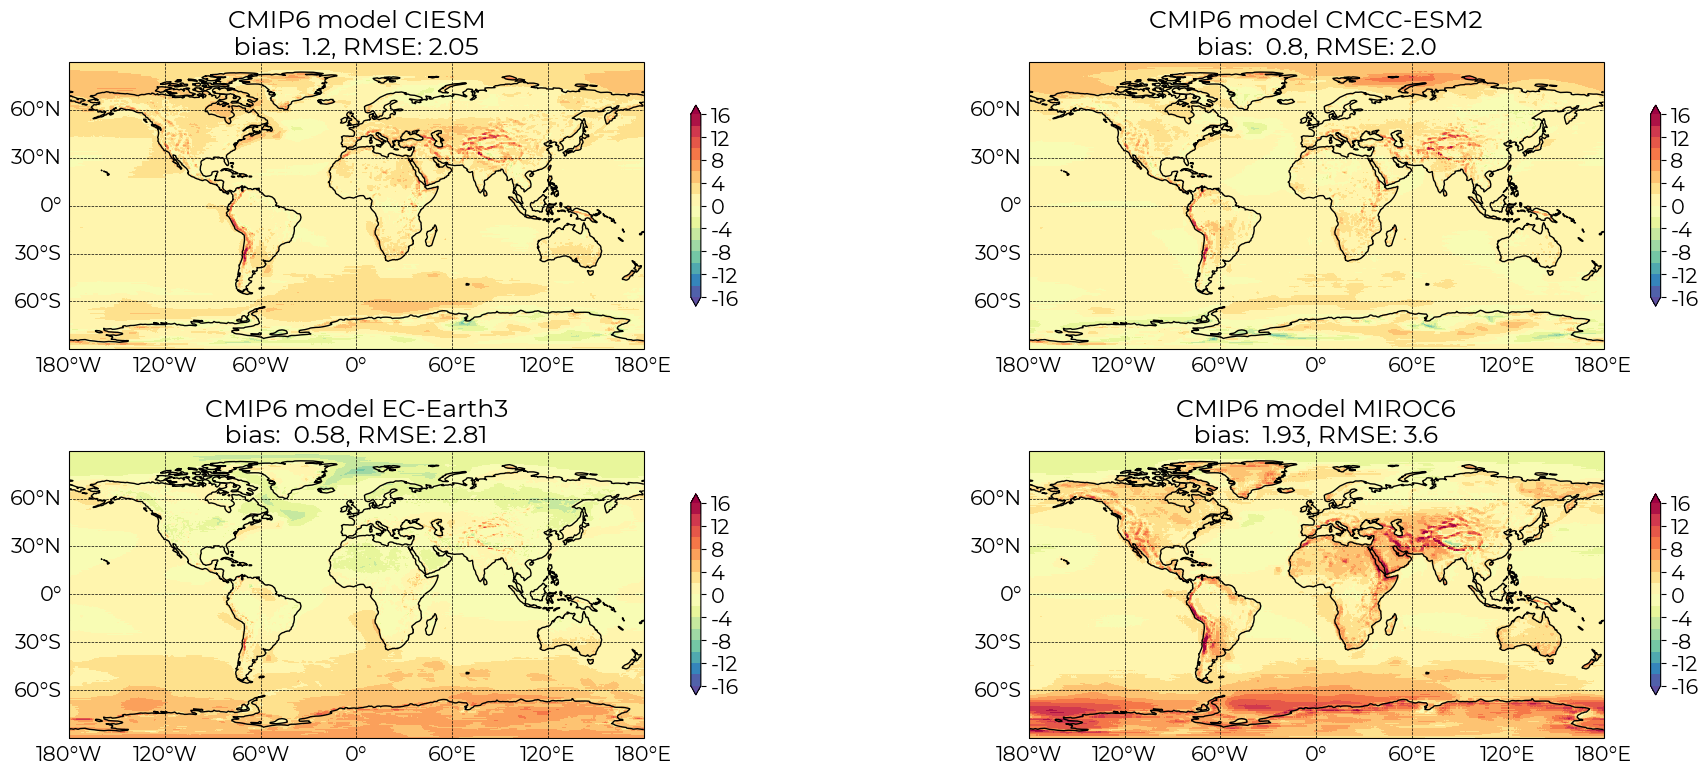

In [11]:
f1, axes = plt.subplots(2, 2,
                        figsize=(20, 8),
                        subplot_kw={'projection': cpy.crs.PlateCarree()})
axes = axes.flatten()

for i, axe in enumerate(axes):
    onemodel = Bclimmodel.sel(model=Bclimmodel.model[i])

    pm.plot_map(onemodel.difference,
                ax=axe,
                colormax=16, colormin=-16, colorlevels=17,
                title=f'CMIP6 model {str(onemodel.model.values)}'
                + f'\n bias:  {round(float(onemodel.bias),2)},'
                + f' RMSE: {round(float(onemodel.RMSE),2)} ')

f1.tight_layout();

In [12]:
# save plot
f1.savefig('CMIP6_and_ERA5.png', format='png', dpi=150)

In [13]:
# docstring
print(pm.plot_map.__doc__)

Plot 2D field with lon-lat grid.

        Call signature::

            plot_map(ds, **kwargs)

            use contourf function from matplotlib.pyplot.
            Could be used for subplots plot due to ax argument.

        Parameters
        ----------
        ds : 2D xarray.DataArray
        The values over which the contour is drawn.

        *ds* must be 2D array with lon-lat coordinates.
        The structure of *ds*:
            ds.coords:
                    lat - 1D array with ``len(lat) == N``, float
                    lon - 1D array with ``len(lon) == M``, flot
                    ds.values -  (N,M) array

        Returns
        -------
        `~.contourf(ds.lon, ds.lat, ds.values)`

        Other Parameters
        ----------------
        ax : a single `~matplotlib.axes.Axes` object, default: None
            Could be used to plot with `~plt.subplots`.

            If not specified:
            ax = plt.axes(projection = cartopy.crs.PlateCarree())

        lat : str, 

### task 3: Principal component analysis

In [14]:
def annual_mean(arr):
    ''' calculate annual mean accounting days in month '''
    # get array containing days in each month
    monlen = arr.time.dt.days_in_month
    # calculate the weights
    weights_month = monlen / monlen.sum()
    # calculate weighted mean
    arrmean = arr.weighted(weights_month).mean("time", keep_attrs=True)
    return arrmean

In [15]:
# calculate annual mean temperature from ERA 5
annualera = era.t2m.groupby("time.year").apply(annual_mean)

In [16]:
with open('annualera.pkl', 'rb') as infile:
    annualera = pickle.load(infile)

In [17]:
# to decouple Europe -> problem with west longitudes
# from 0:360 to -180:180
annualera = annualera.assign_coords(
    {'longitude':
     xr.where(
         annualera.longitude > 180,
         annualera.longitude - 360,
         annualera.longitude)})
annualera = annualera.sortby('longitude')  # 0:180:-180 to -180:0:180

In [43]:
# select region: Europe
lat1 = 35
lat2 = 75
lon1 = -10
lon2 = 40

region = annualera.sel(
    latitude=slice(lat2, lat1),
    longitude=slice(lon1, lon2),
    year=slice(1950, 2022)  # period: 1950-2022
)

#### PCA

In [44]:
# reshape from |year x lat x lon| to |year x (lat*lon)|
regionreshape = region.values.reshape(len(region.year), -1)

# calculate PCA
pca = PCA()
pca.fit(regionreshape)
# eigenvalues, ratio
eigenvalues = pca.explained_variance_ratio_  # |loadings|
# eigenvectors or loadings
loadings = pca.components_  # |loadings x (lat*lon)|
# scores
scores = pca.transform(regionreshape)  # |year x loadings|

# add new variables containing loadings
region = region.to_dataset()
region.coords['eigenvalues'] = eigenvalues
region = region.assign(
    {'pca_loadings': (
        ('eigenvalues', 'latitude', 'longitude'),
        loadings.reshape(region.t2m.values.shape)
    )})

#### Plot

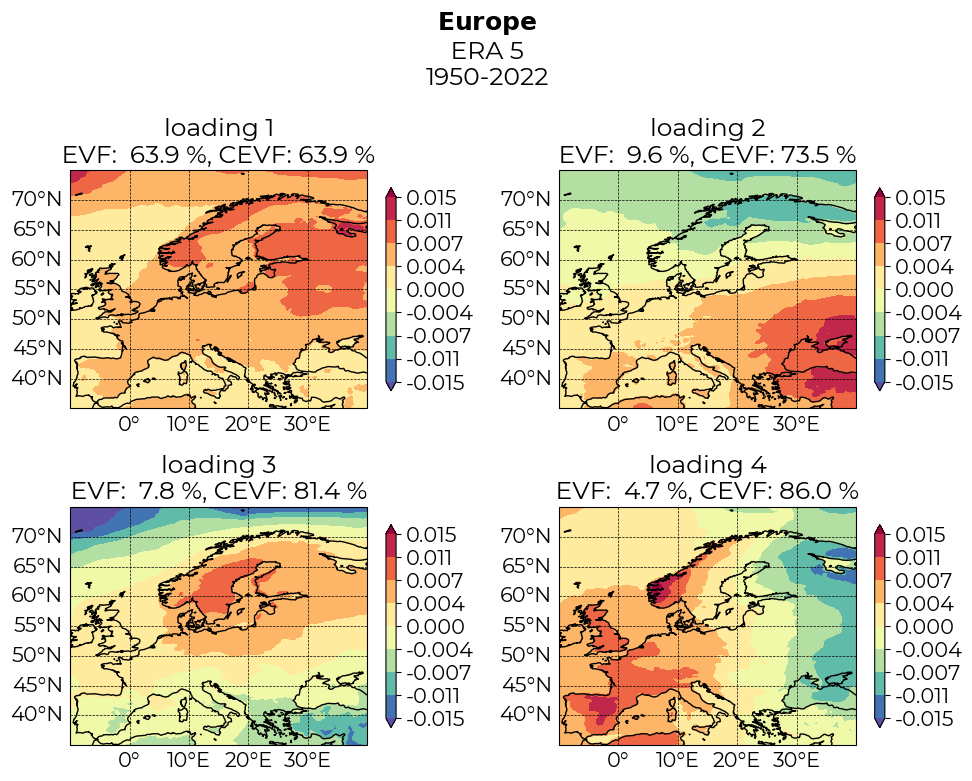

In [20]:
reg = 'Europe'

f2, axes = plt.subplots(2, 2,
                        figsize=(10, 8),
                        subplot_kw={'projection': cpy.crs.PlateCarree()})
axes = axes.flatten()

for i, axe in enumerate(axes):
    oneload = region.sel(eigenvalues=region.eigenvalues[i])

    pm.plot_map(oneload.pca_loadings,
                ax=axe,
                extent=[lon1, lon2, lat1, lat2],
                lat='latitude', lon='longitude',
                fr='%.3f',
                colormax=0.015, colormin=-0.015, colorlevels=9,
                title=f'loading {i+1}'
                + f'\n EVF:  {round(eigenvalues[i]*100,1)} %,'
                + f' CEVF: {round(eigenvalues[:(i+1)].sum()*100,1)} % ')

plt.suptitle(r"$\bf{" + str(reg) + "}$ \n ERA 5 \n1950-2022")

f2.tight_layout();

In [21]:
f2.savefig('PCA_ERA5.png', format='png', dpi=150)

#### Do the loading reflect any familiar oscillation?

**<ins>Loading 1: </ins>**
>The first loading is almost uniform: all stations are positively correlated with a slightly larger correlation in the northeast. It shows that the temperature anomalies distribution in the entire European region is caused by the same large-scale circulation pattern. The localized area of the larger variability in Eastern Europe may be determined due to the greater degree of climatic continentalism of that region relative to the southern and western parts of the continent ( differences in the thermal inertia of land and sea) and therefore the larger amplitude of the seasonal cycle of the temperature. The north area of high values is located in the Scandinavian Mountains, which can reinforce the interannual variability in addition to the interchange of the extremely cold and mild winter (depending on the prevailing air mass: cold arctic air or warmer air from the Atlantic).



In [22]:
season = era.resample(time='Q-NOV').mean()
sload1north = season.sel(longitude=18, latitude=66)
load1north = region.sel(longitude=18, latitude=66)

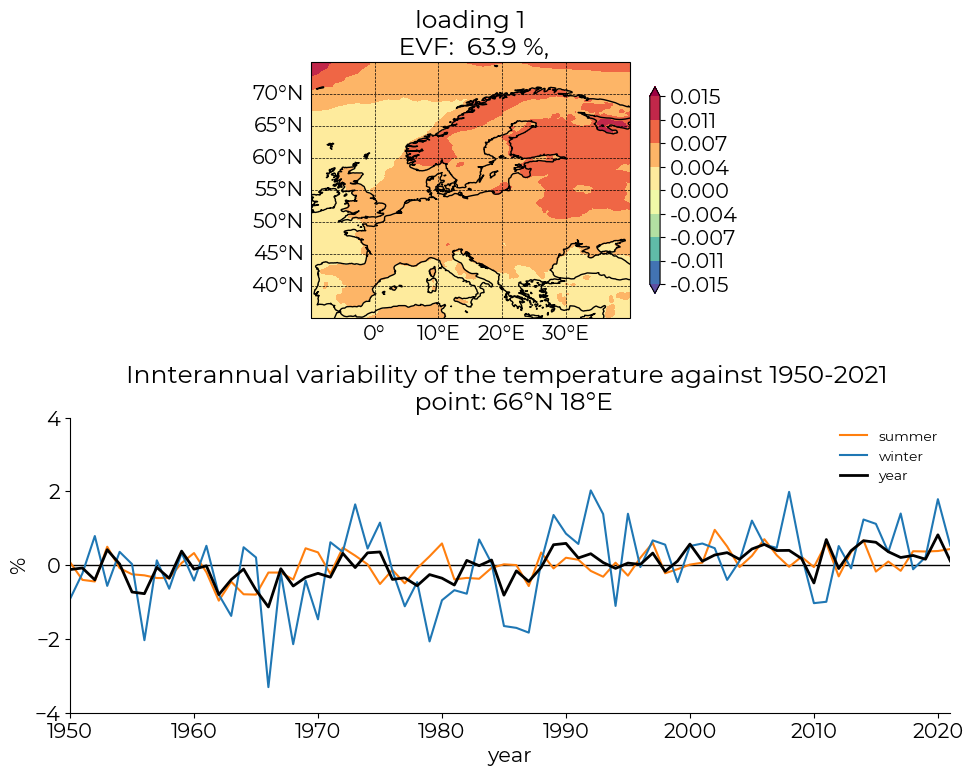

In [23]:
font = {'sans-serif': 'Montserrat', 'size': 8}
plt.rc('font', **font)

fload1 = plt.figure(figsize=(10, 8))
g = gridspec.GridSpec(2, 4)

axload1 = fload1.add_subplot(g[0, 1:3], projection=cpy.crs.PlateCarree())
pm.plot_map(region.sel(eigenvalues=region.eigenvalues[0]).pca_loadings,
            ax=axload1,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.3f',
            colormax=0.015, colormin=-0.015, colorlevels=9,
            title=f'loading 1'
            + f'\n EVF:  {round(eigenvalues[0] * 100,1)} %,')

axpoint = fload1.add_subplot(g[1, :])

axpoint.axhline(y=0, color='black', linewidth=1)

load1northwinter = sload1north.sel(time=season["time.month"] == 2)
load1northsummer = sload1north.sel(time=season["time.month"] == 8)

axpoint.plot(load1north.year,
             ((load1northsummer.t2m / load1northsummer.t2m.mean()) - 1) * 100,
             label=f'summer',
             color='tab:orange',
             linewidth=1.5)

axpoint.plot(load1north.year,
             ((load1northwinter.t2m[:-1]
               / load1northwinter.t2m[:-1].mean()) - 1) * 100,
             label=f'winter',
             color='tab:blue',
             linewidth=1.5)

axpoint.plot(load1north.year,
             ((load1north.t2m / load1north.t2m.mean()) - 1) * 100,
             label=f'year',
             color='black',
             linewidth=2)

axpoint.set_xlabel('year')
axpoint.set_xlim(1950, 2021)
axpoint.set_ylim(-4, 4)
axpoint.set_ylabel('%')
axpoint.set_title('Innterannual variability of '
                  + 'the temperature against 1950-2021'
                  + '\n point: 66°N 18°E')
axpoint.legend(frameon=False, fontsize=10);

fload1.tight_layout();

**<ins>Loading 2: </ins>**
> The second loading describes the contrast in variations between the North (negative sign) and South (positive sign). That interannual variability may be related to the Arctic Oscillation (AO). For example, in 2010, the below-normal temperature was observed in Northern Europe (especially Norway) and above-normal in the South, in 2011 it swapped. 2010 was marked by a strong negative phase of the AO, while 2011 was the year with a positive AO index. According to the figure with the interannual variability, the same pattern with the cold invasion in the North and warm South most likely may occur in the year of the negative AO phase.

In [24]:
AOurl = 'https://www.daculaweather.com/4_ao_index.php#:~:text'
+ '=The%20Arctic%20Oscillation%20(AO)%20is,'
+ 'which%20the%20opposite%20is%20true.'

AOhtml = requests.get(AOurl).content
AO = pd.read_html(AOhtml)[-1]
AO = np.array(AO[13][2:73]).astype(float)
AO = np.append(AO, np.nan)

In [25]:
load2 = region.sel(eigenvalues=region.eigenvalues[1])
idxN = load2.where(load2.pca_loadings <= -0.009, drop=True).squeeze()
idxS = load2.where(load2.pca_loadings >= 0.011, drop=True).squeeze()
Slon = slice(idxS.longitude.min(), idxS.longitude.max())
Slat = slice(idxS.latitude.max(), idxS.latitude.min())
Nlon = slice(idxN.longitude.min(), idxN.longitude.max())
Nlat = slice(idxN.latitude.max(), idxN.latitude.min())
South = load2.sel(longitude=Slon, latitude=Slat).mean(
    ['longitude', 'latitude'])
North = load2.sel(longitude=Nlon, latitude=Nlat).mean(
    ['longitude', 'latitude'])

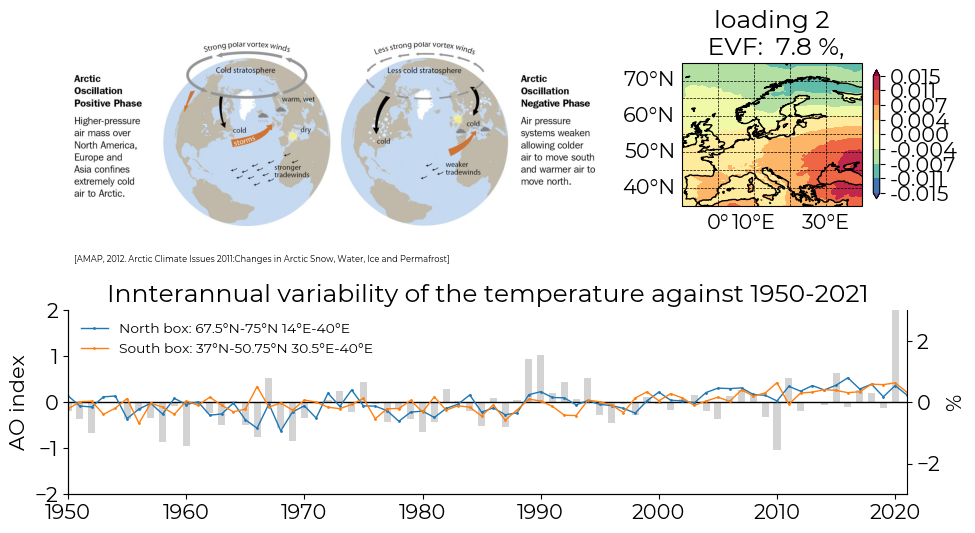

In [26]:
font = {'sans-serif': 'Montserrat', 'size': 6}
plt.rc('font', **font)

fload2 = plt.figure(figsize=(10, 8))
g = gridspec.GridSpec(3, 3)

AOim = image.imread("AO.jpg", format='jpg')
axAO = fload2.add_subplot(g[0, 0:2])
axAO.imshow(AOim)
axAO.annotate('[AMAP, 2012. Arctic Climate Issues 2011:'
              + 'Changes in Arctic Snow, Water, Ice and Permafrost]',
              (0, 0), (0, -20), fontsize=6,
              xycoords='axes fraction', textcoords='offset points', va='top')
axAO.axis('off')


axload2 = fload2.add_subplot(g[0, 2], projection=cpy.crs.PlateCarree())
pm.plot_map(region.sel(eigenvalues=region.eigenvalues[1]).pca_loadings,
            ax=axload2,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.3f',
            colormax=0.015, colormin=-0.015, colorlevels=9,
            title=f'loading 2'
            + f'\n EVF:  {round(eigenvalues[2] * 100,1)} %,')

axAOidx = fload2.add_subplot(g[1, 0:3])
axyear = axAOidx.twinx()
axyear.axhline(y=0, color='black', linewidth=1)
axAOidx.bar(North.year, AO,
            label=f'AO', color='lightgray', width=0.6)
axyear.plot(North.year,
            ((North.t2m / North.t2m.mean()) - 1) * 100,
            label=f'North box: 67.5°N-75°N 14°E-40°E',
            marker='o', markersize=1,
            linewidth=1)
axyear.plot(South.year,
            ((South.t2m / South.t2m.mean()) - 1) * 100,
            label=f'South box: 37°N-50.75°N 30.5°E-40°E',
            marker='o', markersize=1,
            linewidth=1)
axyear.set_xlabel('year')
axyear.set_ylabel('%')
axyear.set_ylim(-3, 3)
axAOidx.set_ylim(-2, 2)
axAOidx.set_ylabel('AO index')
axyear.set_xlim(1950, 2021)
axyear.set_title('Innterannual variability of'
                 + 'the temperature against 1950-2021')
axyear.legend(frameon=False, fontsize=10, loc='upper left')
axyear.spines.right.set_visible(True)

fload2.tight_layout();

**<ins>Loading 3: </ins>**
> The third loading may connect with the NAO oscillation. Northern Europe is more likely to experience cold and dry winters during negative NAO, whereas southern Europe is characterized by warm and wet winters. In the positive phase - oppositely. 

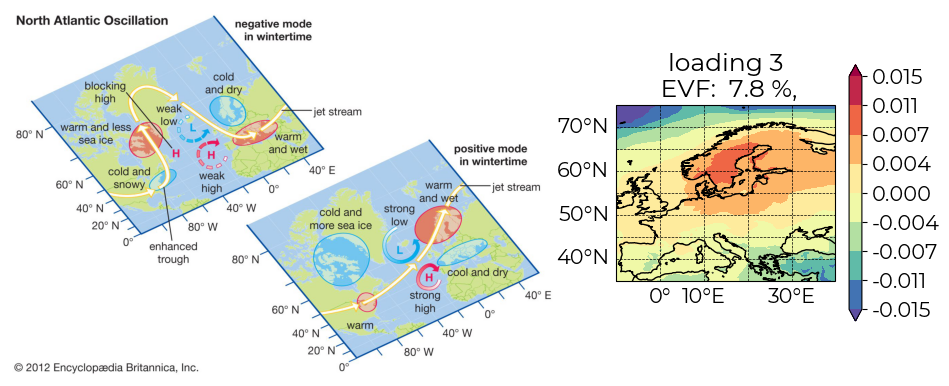

In [27]:
font = {'sans-serif': 'Montserrat', 'size': 8}
plt.rc('font', **font)

fload3 = plt.figure(figsize=(10, 8))
g = gridspec.GridSpec(2, 3)

NAO = image.imread("https://cdn.britannica.com/16/149416-050-536EE6A9/"
                   + "path-jet-stream-modes-North-Atlantic-Oscillation.jpg",
                   format='jpg')
axNAO = fload3.add_subplot(g[0:1, 0:2])
axNAO.imshow(NAO)
axNAO.axis('off')

axload3 = fload3.add_subplot(g[0, 2], projection=cpy.crs.PlateCarree())
pm.plot_map(region.sel(eigenvalues=region.eigenvalues[2]).pca_loadings,
            ax=axload3,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.3f',
            colormax=0.015, colormin=-0.015, colorlevels=9,
            title=f'loading 3'
            + f'\n EVF:  {round(eigenvalues[2] * 100,1)} %,')

fload3.tight_layout();

> The NAO often shares phase with the AO, and it was hardly distinguished which loading corresponds to which oscillation (if it corresponds to any oscillation). The AO is very similar to the NAO, but has a larger horizontal scale and is characterized by greater zonal symmetry. Therefore the first clue was in the more zonal effects on the second loading and more localized over the Scandinavian peninsula in the third loading. The second clue consisted of the comparison of two indexes.

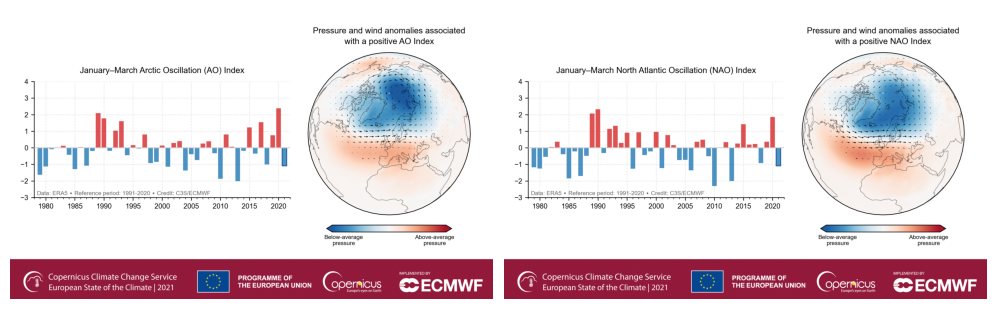

In [28]:
font = {'sans-serif': 'Montserrat', 'size': 8}
plt.rc('font', **font)

fload32 = plt.figure(figsize=(10, 8))
g = gridspec.GridSpec(2, 4)

NAO = image.imread("https://climate.copernicus.eu/sites/default/files/"
                   + "custom-uploads/ESOTC2021/Europe/atmospheric_circulation"
                   + "/C3S_ESOTC21_atmospheric_circulation_fig3b_branded.png",
                   format='png')
axNAO = fload32.add_subplot(g[0, 2:4])
axNAO.imshow(NAO)
axNAO.axis('off')

AO = image.imread("https://climate.copernicus.eu/sites/default/"
                  + "files/custom-uploads/ESOTC2021/Europe/"
                  + "atmospheric_circulation"
                  + "/C3S_ESOTC21_atmospheric_circulation_fig3a_branded.png",
                  format='png')
axAO = fload32.add_subplot(g[0, 0:2])
axAO.imshow(AO)
axAO.axis('off')

fload32.tight_layout();

> Consider one event: <br>
> 2015: + AO and + NAO, 2016: - AO and + NAO <br>
  loading 2: the sigh changes, loading 3: the sigh remains
  
PS: to be honest, it works for most events, but not always

In [45]:
# regionreshape -> |year x (lat*lon)|
# mean('year') t2m |(lat*lon)|
meanreg = regionreshape.mean(axis=0)
# reconstructed t2m -> |year x (lat*lon) x loadings|
rec = np.zeros((regionreshape.shape[0],
                regionreshape.shape[1],
                loadings.shape[0])) + np.nan
for load in range(loadings.shape[0]):
    for grid in range(meanreg.shape[0]):
        L = load + 1  # because [:L]
        rec[:, grid, load] = meanreg[grid]
        + scores[:, load] * loadings[load, grid]

# add new variables containing reconsturcted t2m
regionload = region.assign(
    {'pca_recostructed': (
        ('year', 'latitude', 'longitude', 'eigenvalues'),
        rec.reshape((region.year.shape[0],
                     region.latitude.shape[0],
                     region.longitude.shape[0],
                     region.eigenvalues.shape[0]))
    )})

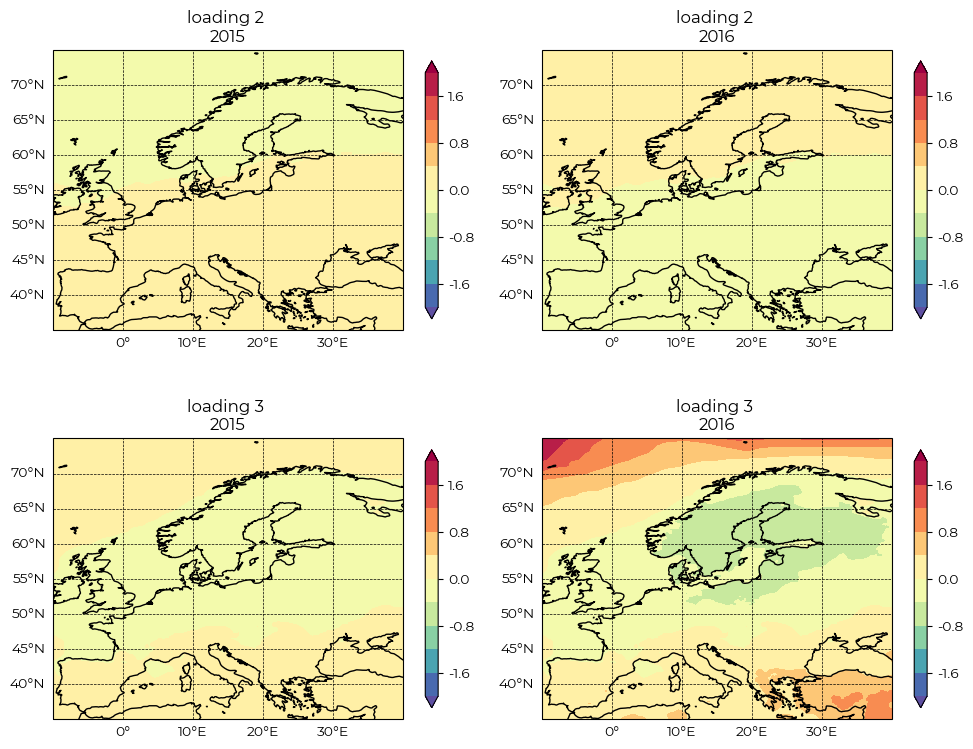

In [46]:
load2 = regionload.sel(eigenvalues=regionload.eigenvalues[1])
load3 = regionload.sel(eigenvalues=regionload.eigenvalues[2])
mean = regionload.t2m.mean('year')

font = {'sans-serif': 'Montserrat', 'size': 6}
plt.rc('font', **font)

fload33 = plt.figure(figsize=(10, 8))
g = gridspec.GridSpec(2, 2)

ax22015 = fload33.add_subplot(g[0, 0], projection=cpy.crs.PlateCarree())
pm.plot_map(load2.sel(year=2015).pca_recostructed - mean,
            ax=ax22015,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.1f',
            fs=10,
            colormax=2, colormin=-2, colorlevels=11,
            title=f'loading 2 \n'
            + '2015')

ax22016 = fload33.add_subplot(g[0, 1], projection=cpy.crs.PlateCarree())
pm.plot_map(load2.sel(year=2016).pca_recostructed - mean,
            ax=ax22016,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.1f',
            fs=10,
            colormax=2, colormin=-2, colorlevels=11,
            title=f'loading 2 \n'
            + '2016')

ax32015 = fload33.add_subplot(g[1, 0], projection=cpy.crs.PlateCarree())
pm.plot_map(load3.sel(year=2015).pca_recostructed - mean,
            ax=ax32015,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.1f',
            fs=10,
            colormax=2, colormin=-2, colorlevels=11,
            title=f'loading 3 \n'
            + '2015')

ax32016 = fload33.add_subplot(g[1, 1], projection=cpy.crs.PlateCarree())
pm.plot_map(load3.sel(year=2016).pca_recostructed - mean,
            ax=ax32016,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.1f',
            fs=10,
            colormax=2, colormin=-2, colorlevels=11,
            title=f'loading 3 \n'
            + '2016')

fload33.tight_layout();

**<ins>Loading 4: </ins>**
> The fourth loading characterizes by the contrast between East and West. It could be induced by the occurrence of blocking anticyclones over Scandinavia and western Russia. For example, there was a significant heat wave event in 2010 caused by the blocking high and corresponds to the record high temperature over the East region (and not over the West). 

I found the Scandinavian pattern https://www.worldclimateservice.com/2021/09/06/scandinavian-pattern/, which is largely driven by a pressure dipole between Southern Europe and Scandinavia. It could be a reason for the fourth loading.

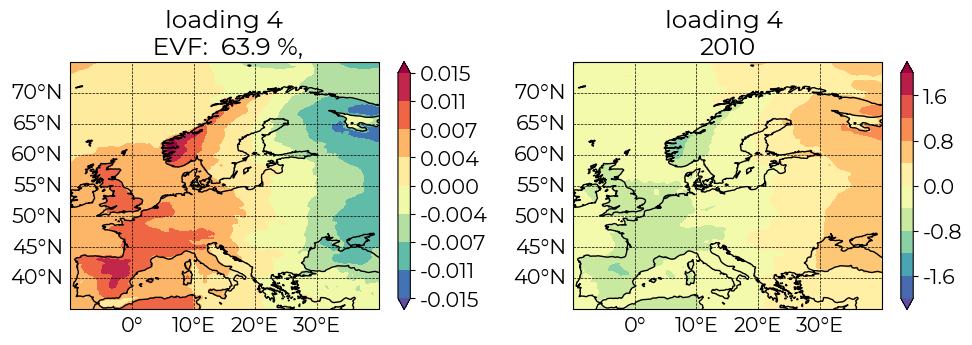

In [47]:
font = {'sans-serif': 'Montserrat', 'size': 8}
plt.rc('font', **font)

fload4 = plt.figure(figsize=(10, 8))
g = gridspec.GridSpec(2, 2)

axload4 = fload4.add_subplot(g[0, 0], projection=cpy.crs.PlateCarree())
pm.plot_map(region.sel(eigenvalues=region.eigenvalues[3]).pca_loadings,
            ax=axload4,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.3f',
            colormax=0.015, colormin=-0.015, colorlevels=9,
            title=f'loading 4'
            + f'\n EVF:  {round(eigenvalues[0] * 100,1)} %,')

load4 = regionload.sel(eigenvalues=regionload.eigenvalues[3])
mean = regionload.t2m.mean('year')

ax42010 = fload4.add_subplot(g[0, 1], projection=cpy.crs.PlateCarree())
pm.plot_map(load4.sel(year=2010).pca_recostructed - mean,
            ax=ax42010,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.1f',
            colormax=2, colormin=-2, colorlevels=11,
            title=f'loading 4 \n'
            + '2010')

fload4.tight_layout();

### task 4: Unit testing

##### Reconstruction

In [48]:
# regionreshape -> |year x (lat*lon)|
# mean('year') t2m |(lat*lon)|
meanreg = regionreshape.mean(axis=0)
# reconstructed t2m -> |year x (lat*lon) x loadings|
rec = np.zeros((regionreshape.shape[0],
                regionreshape.shape[1],
                loadings.shape[0])) + np.nan
for load in range(loadings.shape[0]):
    for grid in range(meanreg.shape[0]):
        L = load + 1  # because [:L]
        rec[:, grid, load] = meanreg[grid] + np.sum(scores[:, :L]
                                                    * loadings[:L, grid],
                                                    axis=1)

##### Example

In [49]:
# add new variables containing reconsturcted t2m
region = region.assign(
    {'pca_recostructed': (
        ('year', 'latitude', 'longitude', 'eigenvalues'),
        rec.reshape((region.year.shape[0],
                     region.latitude.shape[0],
                     region.longitude.shape[0],
                     region.eigenvalues.shape[0]))
    )})
regionmean = region.mean('year')

In [50]:
# Vienna
Vlat = 48.2
Vlon = 16.4

Vt2mERA = region.interp(longitude=Vlon, latitude=Vlat)

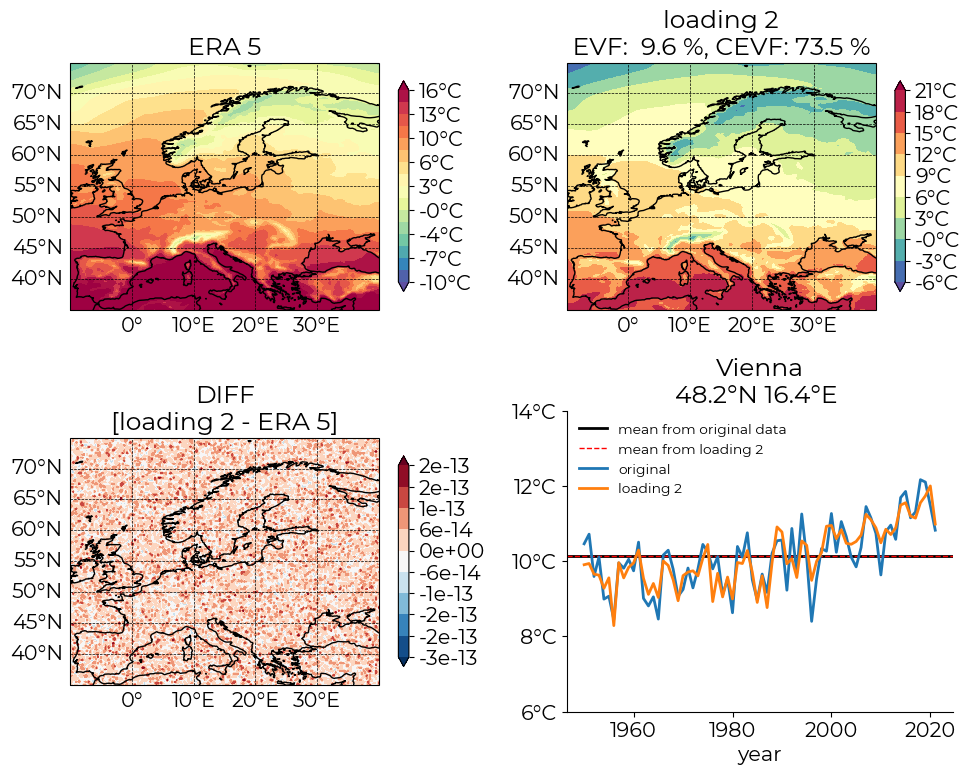

In [51]:
load = 1
f3 = plt.figure(figsize=(10, 8))

axera = f3.add_subplot(221, projection=cpy.crs.PlateCarree())
pm.plot_map(regionmean.t2m - 273.15,
            ax=axera,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.0f°C',
            colormax=16, colormin=-10, colorlevels=17,
            title='ERA 5')

axload1 = f3.add_subplot(222, projection=cpy.crs.PlateCarree())
pm.plot_map(regionmean.pca_recostructed.sel(
            eigenvalues=region.eigenvalues[load]) - 273.15,
            ax=axload1,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.0f°C',
            title=f'loading {load + 1}'
            + f'\n EVF:  {round(eigenvalues[load] * 100,1)} %,'
            + f' CEVF: {round(eigenvalues[:(load + 1)].sum() * 100,1)} % ')

axdiff = f3.add_subplot(223, projection=cpy.crs.PlateCarree())
pm.plot_map(regionmean.pca_recostructed.sel(
            eigenvalues=region.eigenvalues[load]) - regionmean.t2m,
            ax=axdiff,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.0e',
            cmap='RdBu_r',
            title=f'DIFF\n[loading {load + 1} - ERA 5]')

Vload1 = Vt2mERA.pca_recostructed.sel(eigenvalues=Vt2mERA.eigenvalues[load])
axyear = f3.add_subplot(224)
axyear.axhline(y=Vt2mERA.t2m.mean() - 273.15,
               color='black',
               linestyle='-',
               linewidth=2,
               label='mean from original data')
axyear.axhline(y=Vload1.mean() - 273.15,
               color='red',
               linestyle='--',
               linewidth=1,
               label=f'mean from loading {load + 1}')
axyear.plot(Vt2mERA.year,
            Vt2mERA.t2m - 273.15,
            label='original',
            linewidth=2)
axyear.plot(Vt2mERA.year,
            Vload1 - 273.15,
            label=f'loading {load + 1}',
            linewidth=2)
axyear.set_xlabel('year')
axyear.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f°C'))
axyear.legend(frameon=False, fontsize=10)
axyear.set_ylim((6, 14))
axyear.title.set_text('Vienna\n48.2°N 16.4°E ')

f3.tight_layout();

##### Check first loading
<ins>*Results:*</ins> <br>

    Max absolute difference: 5.52088454
    Max relative difference: 0.02083064 

In [52]:
print(testing.assert_allclose(rec[:, :, 0], regionreshape))

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 2329877 / 2329992 (100%)
Max absolute difference: 6.90092631
Max relative difference: 0.02458775
 x: array([[267.028402, 267.247243, 267.444226, ..., 293.1402  , 293.523996,
        293.739308],
       [266.546143, 266.763523, 266.95913 , ..., 292.989762, 293.374081,...
 y: array([[266.015423, 266.244703, 266.456677, ..., 292.197943, 292.533809,
        292.714588],
       [264.157954, 264.429237, 264.679941, ..., 293.396689, 293.744973,...

##### Check last loading
<ins>*Results:*</ins> <br>
   with rtol=1e-07 : None <br>
   . <br>
   . <br>
   . <br>
   with rtol=1e-15 :
    
    Max absolute difference: 1.1937118e-12
    Max relative difference: 4.37096812e-15

In [53]:
print(testing.assert_allclose(rec[:, :, -1], regionreshape))

None


In [54]:
print(testing.assert_allclose(rec[:, :, -1], regionreshape, rtol=1e-15))

AssertionError: 
Not equal to tolerance rtol=1e-15, atol=0

Mismatched elements: 53 / 2329992 (0.00227%)
Max absolute difference: 1.36424205e-12
Max relative difference: 5.07497733e-15
 x: array([[266.015423, 266.244703, 266.456677, ..., 292.197943, 292.533809,
        292.714588],
       [264.157954, 264.429237, 264.679941, ..., 293.396689, 293.744973,...
 y: array([[266.015423, 266.244703, 266.456677, ..., 292.197943, 292.533809,
        292.714588],
       [264.157954, 264.429237, 264.679941, ..., 293.396689, 293.744973,...

In [55]:
# calculate matched elements with rtol=1e-7
rtol = 1e-7
N = loadings.shape[0] * loadings.shape[1]
matched = np.zeros(loadings.shape[0]) + np.nan
for load in range(loadings.shape[0]):
    matched[load] = np.isclose(rec[:, :, load], regionreshape, rtol=rtol).sum()

# in %
percmatched = (matched / N) * 100

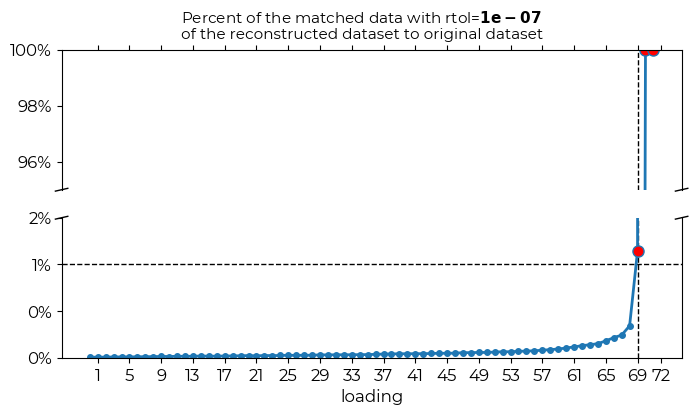

In [56]:
# formatting plot
font = {'sans-serif': 'Montserrat', 'size': 12}
axes = {'spines.top': True, 'spines.right': True}
plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', linewidth=1)

f4, (axtop, axbottom) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# indicate loadings where matched >= 1%
axtop.axvline(x=69, color='black', linestyle='--', linewidth=1)
axbottom.axvline(x=69, color='black', linestyle='--', linewidth=1)
axbottom.axhline(y=1, color='black', linestyle='--', linewidth=1)

# plot % matched data
axtop.plot(percmatched,
           marker='o', markersize=8, markerfacecolor='red',
           linewidth=2)
axbottom.plot(percmatched,
              marker='o', markersize=4,
              linewidth=2)
axbottom.plot(69, percmatched[-3],
              marker='o', markersize=8,
              markerfacecolor='red', markeredgecolor='tab:blue',
              linewidth=2)

'''AXES'''
# set xticks label
axbottom.set_xticks(np.append(np.arange(1, 72, 4), 72))
axtop.set_xticks(np.append(np.arange(1, 72, 4), 72))

# limit the view
axtop.set_ylim(95, 100)
axbottom.set_ylim(0, 1.5)

# yticks in %
axtop.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axbottom.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# hide the spines between axtop and axbottom
axtop.spines['bottom'].set_visible(False)
axbottom.spines['top'].set_visible(False)
axtop.xaxis.tick_top()
axtop.tick_params(labeltop=False)
axbottom.xaxis.tick_bottom()

# add diagonal lines at yaxes
d = .01  # how big

# to the top axes
kwargs = dict(transform=axtop.transAxes, color='k', clip_on=False)
axtop.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axtop.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
# switch to the bottom axes
kwargs.update(transform=axbottom.transAxes)
axbottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axbottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagona

'''LABELS'''
axbottom.set_xlabel('loading')
f4.suptitle('Percent of the matched data with '
            + r"rtol=$\bf{" + str(rtol) + "}$"
            + '\nof the reconstructed dataset to original dataset',
            fontsize=11);

### task 5: Publication of your code on GitHub

##### Check flake8

###### flake8 for .py

In [57]:
%%bash
flake8 plotmap.py
flake8 fcmip6.py

###### flake8 for .ipynb
***NOTE: --ignore=E402,E703,W503,E999***

    E402 module level import not at top of file 
         -> stylistically challenging for Jupyter Notebook (title,...)
    E703 statement ends with a semicolon 
         -> don't want to print data before plots
    W503 line break before binary operator 
         -> changed on April 16th, 2016 
         -> NOW: line breaks should occur before the binary operator
    E999 SyntaxError: invalid syntax
         -> problem with %%bash 